## Analysis of relative expression

- Processing warnings

In [68]:
import warnings
warnings.filterwarnings('ignore')

- Loading modules

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

- Loading raw data

In [70]:
df_data = pd.read_excel("../raw_data/relative_expression.xlsx", sheet_name="relative_expression")
df_data = df_data[["sample", "expression", "treat", "time"]]
df_data

,sample,expression,treat,time
0,1,1.609675,0,0
1,1,1.705633,0,0
2,1,1.839750,0,0
3,1,1.690755,0,0
4,1,1.663931,0,0
...,...,...,...,...
115,152,0.544677,42,28
116,153,0.976968,42,28
117,154,0.417831,42,28
118,155,0.788235,42,28


In [71]:
df_data["time"].value_counts()

0     23
7     21
21    21
14    20
4     18
28    17
Name: time, dtype: int64

In [72]:
df_data["treat"].value_counts()

36    29
34    28
42    28
0     23
49    12
Name: treat, dtype: int64

In [73]:
df_data["treat"] = df_data["treat"].replace({0: "Time Zero (34g/L)", 34: "34 g/L (Control)", 
                                           36: "36.4 g/L", 42: "45.8 g/L",
                                           49: "51.8 g/L"})

- Creating plot

In [74]:
df_data.columns = ["sample", "Relative Expression",	"Dilutions of brine", "Days"]

In [75]:
personalized_pallete = ["#bee9e8", "#62b6cb", "#1b4965", 
                  "#cae9ff", "#5fa8d3"]

In [76]:
df_data["Dilutions of brine"] = df_data["Dilutions of brine"].astype(str)
df_data["Days"] = df_data["Days"].astype(int)

In [77]:
hue_order = sorted(df_data["Dilutions of brine"].unique())
x_ticks = sorted(df_data["Days"].unique())
bar_width = 0.8

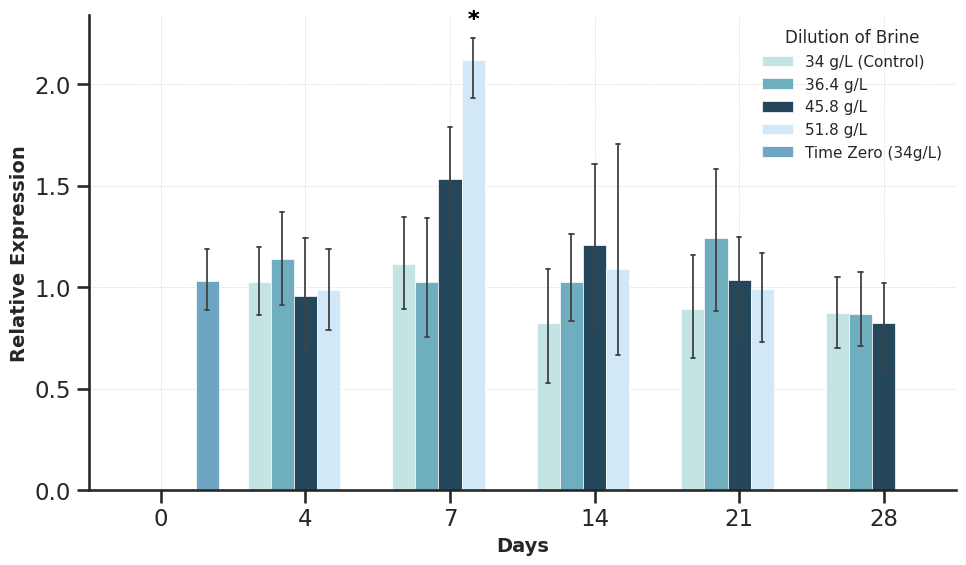

In [78]:
sns.set(style="ticks", context="talk", font_scale=1.0)
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=df_data,
    x="Days",
    y="Relative Expression",
    hue="Dilutions of brine",
    palette=personalized_pallete,
    capsize=0.15,
    errwidth=1.3,
    linewidth=0.5,
    hue_order=hue_order
)

ax.set_xlabel("Days", fontsize=14, weight='bold')
ax.set_ylabel("Relative Expression", fontsize=14, weight='bold')
ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)
ax.legend(title="Dilution of Brine", title_fontsize=12, fontsize=11, loc='upper right', frameon=False)
sns.despine()

alpha = 0.05

for i, day in enumerate(x_ticks):
    subdata = df_data[df_data["Days"] == day]
    
    valid_groups = subdata["Dilutions of brine"].value_counts()
    valid_groups = valid_groups[valid_groups >= 2]

    if len(valid_groups) < 2:
        continue
    
    subdata = subdata[subdata["Dilutions of brine"].isin(valid_groups.index)]

    tukey = pairwise_tukeyhsd(
        endog=subdata["Relative Expression"],
        groups=subdata["Dilutions of brine"],
        alpha=alpha
    )
    
    for res in tukey.summary().data[1:]:
        group1, group2, meandiff, pval, lower, upper, reject = res
        if reject:
            offset1 = hue_order.index(group1)
            offset2 = hue_order.index(group2)
            group_count = len(hue_order)
            spacing = bar_width / group_count
            center = i 

            x1 = center - bar_width / 2 + spacing * (offset1 + 0.5)
            x2 = center - bar_width / 2 + spacing * (offset2 + 0.5)

            y1 = subdata[subdata["Dilutions of brine"] == group1]["Relative Expression"].mean()
            y2 = subdata[subdata["Dilutions of brine"] == group2]["Relative Expression"].mean()

            if y1 > y2:
                x_ast, y_ast = x1, y1
            else:
                x_ast, y_ast = x2, y2

            ax.text(
                x_ast,
                y_ast + 0.15,
                "*", 
                ha='center',
                va='bottom',
                fontsize=16,
                weight='bold',
                color='black'
            )

plt.tight_layout()
plt.savefig("../figures_paper/relative_expression_tukey.png", dpi=300)
plt.show()